In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import urllib.request

url = 'http://ergast.com/downloads/f1db_csv.zip'
filehandle, _ = urllib.request.urlretrieve(url)
zf = zipfile.ZipFile(filehandle, 'r')

results_df = pd.read_csv(zf.open('results.csv'))
drivers_df = pd.read_csv(zf.open('drivers.csv'))
lap_times_df = pd.read_csv(zf.open('lap_times.csv'))
races_df = pd.read_csv(zf.open('races.csv'))
pit_stops_df = pd.read_csv(zf.open('pit_stops.csv'))
constructors_df = pd.read_csv(zf.open('constructors.csv'))
circuits_df = pd.read_csv(zf.open('circuits.csv'))
pit_stops_df = pd.read_csv(zf.open('pit_stops.csv'))

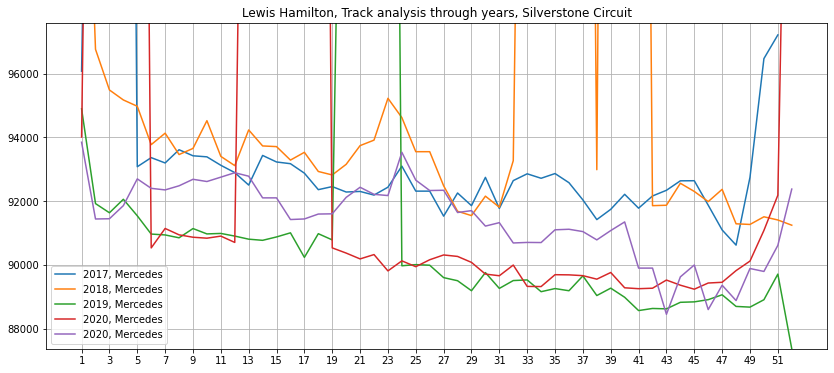

In [2]:
circuitRef = 'silverstone'
circuitId = circuits_df[circuits_df.circuitRef == circuitRef]['circuitId'].iloc[0]

driverRef = 'hamilton'
driverId = drivers_df[drivers_df.driverRef == driverRef]['driverId'].iloc[0]

plt.figure(figsize=(14, 6))    

ms_max, ms_min = [], []

for raceId in races_df[races_df.circuitId == circuitId].sort_values("year").raceId.iloc[-5:]:
    race_df = lap_times_df[(lap_times_df.raceId == raceId) & (lap_times_df.driverId == driverId)].copy()
    
    pit_stop_df = pit_stops_df[(pit_stops_df.raceId == raceId) & (pit_stops_df.driverId == driverId)]

    for lap in pit_stop_df.lap:
        race_df.loc[race_df.lap.isin([lap, lap + 1]),'milliseconds'] = np.nan
        mean_value = race_df.loc[race_df.lap.isin([lap - 1, lap + 2])].milliseconds.mean()
        race_df.loc[race_df.lap.isin([lap, lap + 1]),'milliseconds'] = mean_value
    
    ms_max.append(race_df.milliseconds.max())
    ms_min.append(race_df.milliseconds.min())
    
    race_year = str(races_df[races_df.raceId == raceId].year.iloc[0])
    constructorId = results_df[(results_df.raceId == raceId) & (results_df.driverId == driverId)].constructorId.iloc[0]
    constructor_name = constructors_df[constructors_df.constructorId == constructorId].name.iloc[0]
    label = race_year + ', ' + constructor_name
    plt.plot(race_df.lap,
             race_df.milliseconds,
             label = label)

plt.legend()
last_5_raceId = races_df[races_df.circuitId == circuitId].sort_values("year").raceId.iloc[-5:]
race_df = lap_times_df[(lap_times_df.raceId.isin(last_5_raceId)) & (lap_times_df.driverId == driverId)].copy()
q1 = race_df.milliseconds.quantile(0.25)
q3 = race_df.milliseconds.quantile(0.75)
cons = (q3 - q1) * 1.5
high_lim = q3 + cons
low_lim = q1 - cons
plt.ylim(race_df.milliseconds.min(),
         high_lim)
driver_forename = drivers_df[drivers_df.driverRef == driverRef].forename.iloc[0]
driver_surname = drivers_df[drivers_df.driverRef == driverRef].surname.iloc[0]
circuit_name = circuits_df[circuits_df.circuitRef == circuitRef].name.iloc[0]
plt.title(driver_forename + ' ' + driver_surname + ', Track analysis through years, ' + circuit_name)
plt.grid()
plt.xticks(np.arange(race_df["lap"].values.min(), race_df["lap"].values.max()+1, 2.0))
plt.show()